In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
import sys
sys.path.append("/work")
import helper
from dask.distributed import Client
import importlib, helper; importlib.reload(helper)
from pathlib import Path
# ToDo Add quality filter^


In [2]:
client = Client()
auth = earthaccess.login("login.netrc")

2025-10-15 22:12:22,283 - distributed.scheduler - WARNING - Failed to format dashboard link, unknown value: 'JUPYTERHUB_SERVICE_PREFIX'


In [5]:
# --- REGION ---

region = (12.572136,35.345655,30.413933,49.060595) # bbox balkan region

# --- TIME ---

tspan = ("2024-03-01 00:00", "2025-08-01 00:00")

# --- OUTPUT ---

# Path where your Balkan data is stored
data_dir = Path("/work/balkan/oci")

# --- REGION ---
df = pd.read_csv("/work/balkan_plants.csv")

# Extract latitude and longitude
coords = df[['Latitude', 'Longitude']].values

# Convert to radians for haversine
coords_rad = np.radians(coords)

# Compute the distance matrix using haversine
dist_matrix = haversine_distances(coords_rad)

# Define epsilon in radians (e.g., ~100 km)
earth_radius_km = 6371
max_distance_km = 50
epsilon = max_distance_km / earth_radius_km

# Apply DBSCAN with precomputed distances
db = DBSCAN(eps=epsilon, min_samples=1, metric='precomputed')
clusters = db.fit_predict(dist_matrix)

# Add cluster labels to the DataFrame
df['Cluster'] = clusters

cluster_means = df[df['Cluster'] != -1].groupby('Cluster')[['Latitude', 'Longitude']].mean().reset_index()

# Group by cluster and print the results
print("Clustered Coal Plants:")
for cluster_id in sorted(df['Cluster'].unique()):
    if cluster_id == -1:
        print("\nNoise (unclustered):")
    else:
        print(f"\nCluster {cluster_id}:")
        # Get mean coordinates for this cluster
        mean_coords = cluster_means[cluster_means['Cluster'] == cluster_id]
        if not mean_coords.empty:
            mean_lat = mean_coords['Latitude'].iloc[0]
            mean_lon = mean_coords['Longitude'].iloc[0]
            print(f"Mean Coordinates: Latitude = {mean_lat:.6f}, Longitude = {mean_lon:.6f}")
    cluster_df = df[df['Cluster'] == cluster_id]
    for _, row in cluster_df.iterrows():
        print(f"- {row['Name']} ({row['Country']}) at ({row['Latitude']}, {row['Longitude']})")


Clustered Coal Plants:

Cluster 0:
Mean Coordinates: Latitude = 40.401946, Longitude = 21.856229
- Agios Dimitrios power station (Greece) at (40.394185, 21.924886)
- Ptolemaïda power station (Greece) at (40.409707, 21.787573)

Cluster 1:
Mean Coordinates: Latitude = 44.575826, Longitude = 20.225978
- Nikola Tesla power station (Serbia) at (44.671341, 20.158418)
- Kolubara A power station (Serbia) at (44.480312, 20.293538)

Cluster 2:
Mean Coordinates: Latitude = 42.446471, Longitude = 23.055765
- Republika power station (Bulgaria) at (42.607124, 23.078699)
- Bobov Dol power station (Bulgaria) at (42.285818, 23.03283)

Cluster 3:
Mean Coordinates: Latitude = 42.684787, Longitude = 21.070962
- Kosovo A power station (Kosovo) at (42.676454, 21.085922)
- Kosovo B power station (Kosovo) at (42.69312, 21.056002)

Cluster 4:
Mean Coordinates: Latitude = 41.058320, Longitude = 21.484266
- Bitola power station (North Macedonia) at (41.05832, 21.484266)

Cluster 5:
Mean Coordinates: Latitude = 4

In [29]:

results = earthaccess.search_data(
short_name="CIESIN_SEDAC_GPWv4_POPDENS_R11",
granule_name="gpw-v4-population*2pt5*nc*"
)
earthaccess.open(results)
downloaded_files = earthaccess.download(
    results,
    local_path='/work',
)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

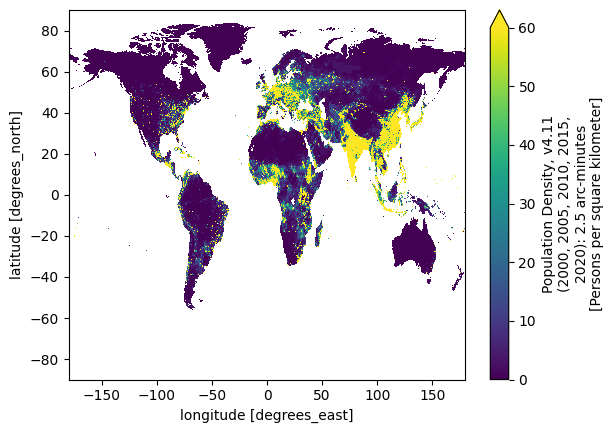

In [59]:
pop = xr.open_mfdataset("/work/gpw_v4_population_density_rev11_2pt5_min.nc")
pop = pop.isel(raster=0).squeeze()
pop = pop.reset_coords(drop=True)

pop = pop["Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes"]
pop.plot(vmin=0, vmax=60)
# assume your DataArray is named pop
# e.g. pop = ds["Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes"]


In [58]:
np.nanmean(pop)

np.float32(39.705776)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [5]:
# Generate a list of months within the time span
months = pd.date_range(tspan[0], tspan[1], freq="MS")  # "MS" = Month Start

monthly_datasets = []

for month_start in months:
    
    month_end = (month_start + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d %H:%M")
    month_str = month_start.strftime("%Y%m")  # e.g., "202403"
    paths_month = list(data_dir.glob(f"*{month_str}*"))

    # Find all files for that month
    if not paths_month:
        print(f"No files found for {month_str}, skipping...")
        continue
    #print(paths_month)
    print(len(paths_month))
    print(f"Start loading oci data for the month {month_str}")
    

    kwargs = {"combine": "nested", "concat_dim": "time"}
    attrs = xr.open_mfdataset(paths_month, preprocess=helper.time_from_attr_2, **kwargs).load()
    oci = xr.open_mfdataset(
        paths_month,
        combine="nested",
        concat_dim="time",
        chunks={"time": -1, "lat": 1800, "lon": 3600}
    )
    oci["time"] = attrs

    oci_sel = oci['Aerosol_Optical_Depth_550'].sel(
        lon=slice(region[0], region[2]),
    ).load()
    oci_sel = oci_sel.sortby("time")
    oci_sel = oci_sel.sel(time=~oci.get_index("time").duplicated())
    
    oci_sel = oci_sel.sortby("lat")

    oci_sel = oci_sel.sel(
        lat=slice(region[1], region[3]),
        time=slice(tspan[0], tspan[1])
    ).load()

    monthly_datasets.append(oci_sel)
    
oci_all = xr.concat(monthly_datasets, dim="time")

23
Start loading oci data for the month 202403
30
Start loading oci data for the month 202404
26
Start loading oci data for the month 202405
30
Start loading oci data for the month 202406
31
Start loading oci data for the month 202407
31
Start loading oci data for the month 202408
28
Start loading oci data for the month 202409
30
Start loading oci data for the month 202410
30
Start loading oci data for the month 202411
30
Start loading oci data for the month 202412
30
Start loading oci data for the month 202501
28
Start loading oci data for the month 202502
31
Start loading oci data for the month 202503
30
Start loading oci data for the month 202504
29
Start loading oci data for the month 202505
30
Start loading oci data for the month 202506
31
Start loading oci data for the month 202507
31
Start loading oci data for the month 202508


In [11]:
oci_all.coords["season"] = oci_all["time"].dt.season


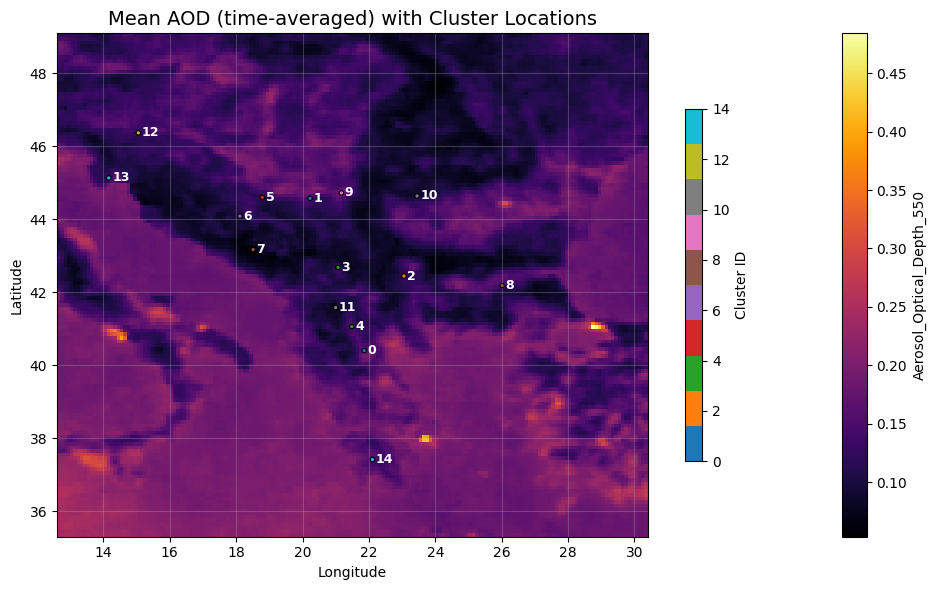

In [26]:
import matplotlib.pyplot as plt

# Take temporal mean (mean AOD map)
mean_map = oci_all.mean(dim="time")

# Create figure and plot AOD
fig, ax = plt.subplots(figsize=(10, 6))
mean_map.plot(ax=ax, cmap="inferno")

# Overlay cluster locations
sc = ax.scatter(
    cluster_means["Longitude"],
    cluster_means["Latitude"],
    c=cluster_means["Cluster"],
    cmap="tab10",
    s=10,
    edgecolors="black",
    linewidths=0.8,
    zorder=10,
)

# Add labels for cluster IDs
for _, row in cluster_means.iterrows():
    ax.text(
        row["Longitude"] + 0.1,  # small offset to avoid overlap
        row["Latitude"],
        f"{int(row['Cluster'])}",
        color="white",
        fontsize=9,
        weight="bold",
        ha="left",
        va="center",
        zorder=11,
    )

# Styling
ax.set_title("Mean AOD (time-averaged) with Cluster Locations", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(alpha=0.3)

# Add colorbar for cluster IDs
cbar = plt.colorbar(sc, ax=ax, shrink=0.7)
cbar.set_label("Cluster ID")

plt.tight_layout()
plt.show()

In [19]:
factors = [1, 2, 3, 4, 5]

aod_mean = []
aod_std = []

lon_res = 0.1
lat_res = 0.1


def area_plot(da, lon_res, lat_res, mid, factor=1):


    lon = da.lon
    lat = da.lat

    radius = factor * lat_res  # radius in degrees (approx)

    # check if da has any non-NaN values
    if not da.notnull().any():
        return None

    da_filtered = da.where(
        ( (factor * lat_res - lat_res)**2 <= ((lat - mid[1])**2 + (lon - mid[0])**2) ) & ( ((lat - mid[1])**2 + (lon - mid[0])**2) < radius**2 ),
        #( np.abs(lat - mid[1]) < radius ) & ( np.abs(lon - mid[0]) < 0.5 ) ,
        drop=True
    )
    
    
    # check if da has any non-NaN values
    if not da_filtered.notnull().any():
        return None
    
    return da_filtered

for _, row in cluster_means.iterrows():
    
    aod_mean_f = []
    aod_std_f = []
    ae_mean_f = []
    ae_std_f = []
        
    cluster_id = int(row['Cluster'])
    
    mean_lat = row['Latitude']
    mean_lon = row['Longitude']
    print(f"\nCluster {cluster_id}:")
    print(f"Mean Coordinates: Latitude = {mean_lat:.6f}, Longitude = {mean_lon:.6f}")


    mid = ( mean_lon, mean_lat )
    
    # Keep your original convention
    lat_res = 0.1
    lon_res = 0.1

    for f in factors:        
        da_f = area_plot(oci_all, lon_res, lat_res, mid, f)
        if da_f is None:
                        
                        
            aod_mean_f.append(np.nan)
            aod_std_f.append(np.nan)
            continue

        # Compute spatial mean first
        da_space_mean = da_f.mean(dim=["lon", "lat"], skipna=True)

        # Group by season and compute mean/std over time
        seasonal_mean = da_space_mean.groupby("time.season").mean(skipna=True)
        seasonal_std  = da_space_mean.groupby("time.season").std(skipna=True)
                
        aod_mean_f.append(seasonal_mean)
        aod_std_f.append(seasonal_std)
            


    aod_mean.append(aod_mean_f)
    aod_std.append(aod_std_f)



Cluster 0:
Mean Coordinates: Latitude = 40.401946, Longitude = 21.856229

Cluster 1:
Mean Coordinates: Latitude = 44.575826, Longitude = 20.225978

Cluster 2:
Mean Coordinates: Latitude = 42.446471, Longitude = 23.055765

Cluster 3:
Mean Coordinates: Latitude = 42.684787, Longitude = 21.070962

Cluster 4:
Mean Coordinates: Latitude = 41.058320, Longitude = 21.484266

Cluster 5:
Mean Coordinates: Latitude = 44.602243, Longitude = 18.787479

Cluster 6:
Mean Coordinates: Latitude = 44.089633, Longitude = 18.113865

Cluster 7:
Mean Coordinates: Latitude = 43.172137, Longitude = 18.511555

Cluster 8:
Mean Coordinates: Latitude = 42.185458, Longitude = 26.015139

Cluster 9:
Mean Coordinates: Latitude = 44.723674, Longitude = 21.171605

Cluster 10:
Mean Coordinates: Latitude = 44.641098, Longitude = 23.451097

Cluster 11:
Mean Coordinates: Latitude = 41.582000, Longitude = 21.000000

Cluster 12:
Mean Coordinates: Latitude = 46.372300, Longitude = 15.053400

Cluster 13:
Mean Coordinates: Lati

In [20]:
import pandas as pd

records = []
for c_idx, c in enumerate(clusters):
    for f_idx, f in enumerate(factors):
        mean_da = aod_mean[c_idx][f_idx]
        std_da  = aod_std[c_idx][f_idx]
        for season in mean_da.season.values:
            records.append({
                "Cluster": c,
                "Factor": f,
                "Season": str(season),
                "AOD_Mean": float(mean_da.sel(season=season).values),
                "AOD_STD":  float(std_da.sel(season=season).values)
            })
df_seasonal = pd.DataFrame(records)

In [21]:
df_seasonal

,Cluster,Factor,Season,AOD_Mean,AOD_STD
0,0,1,DJF,0.059746,0.063453
1,0,1,JJA,0.262458,0.151846
2,0,1,MAM,0.126715,0.147713
3,0,1,SON,0.080879,0.106133
4,0,2,DJF,0.061453,0.057112
...,...,...,...,...,...
295,14,4,SON,0.093363,0.078729
296,14,5,DJF,0.097733,0.057203
297,14,5,JJA,0.225718,0.130555
298,14,5,MAM,0.200717,0.165771


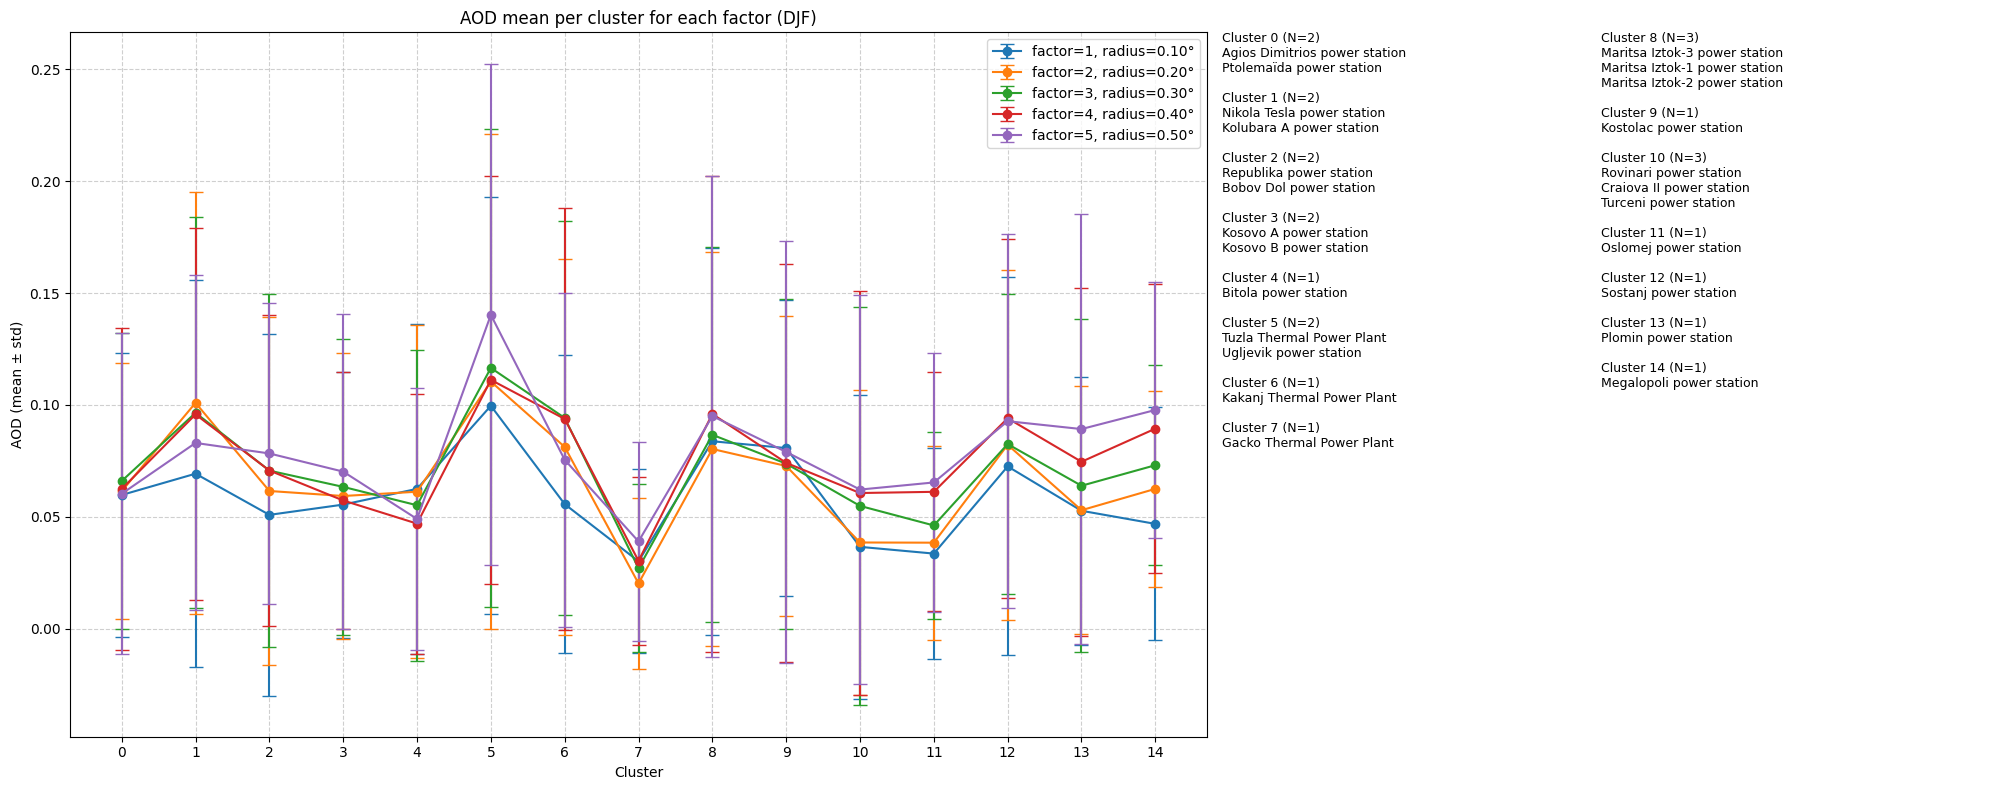

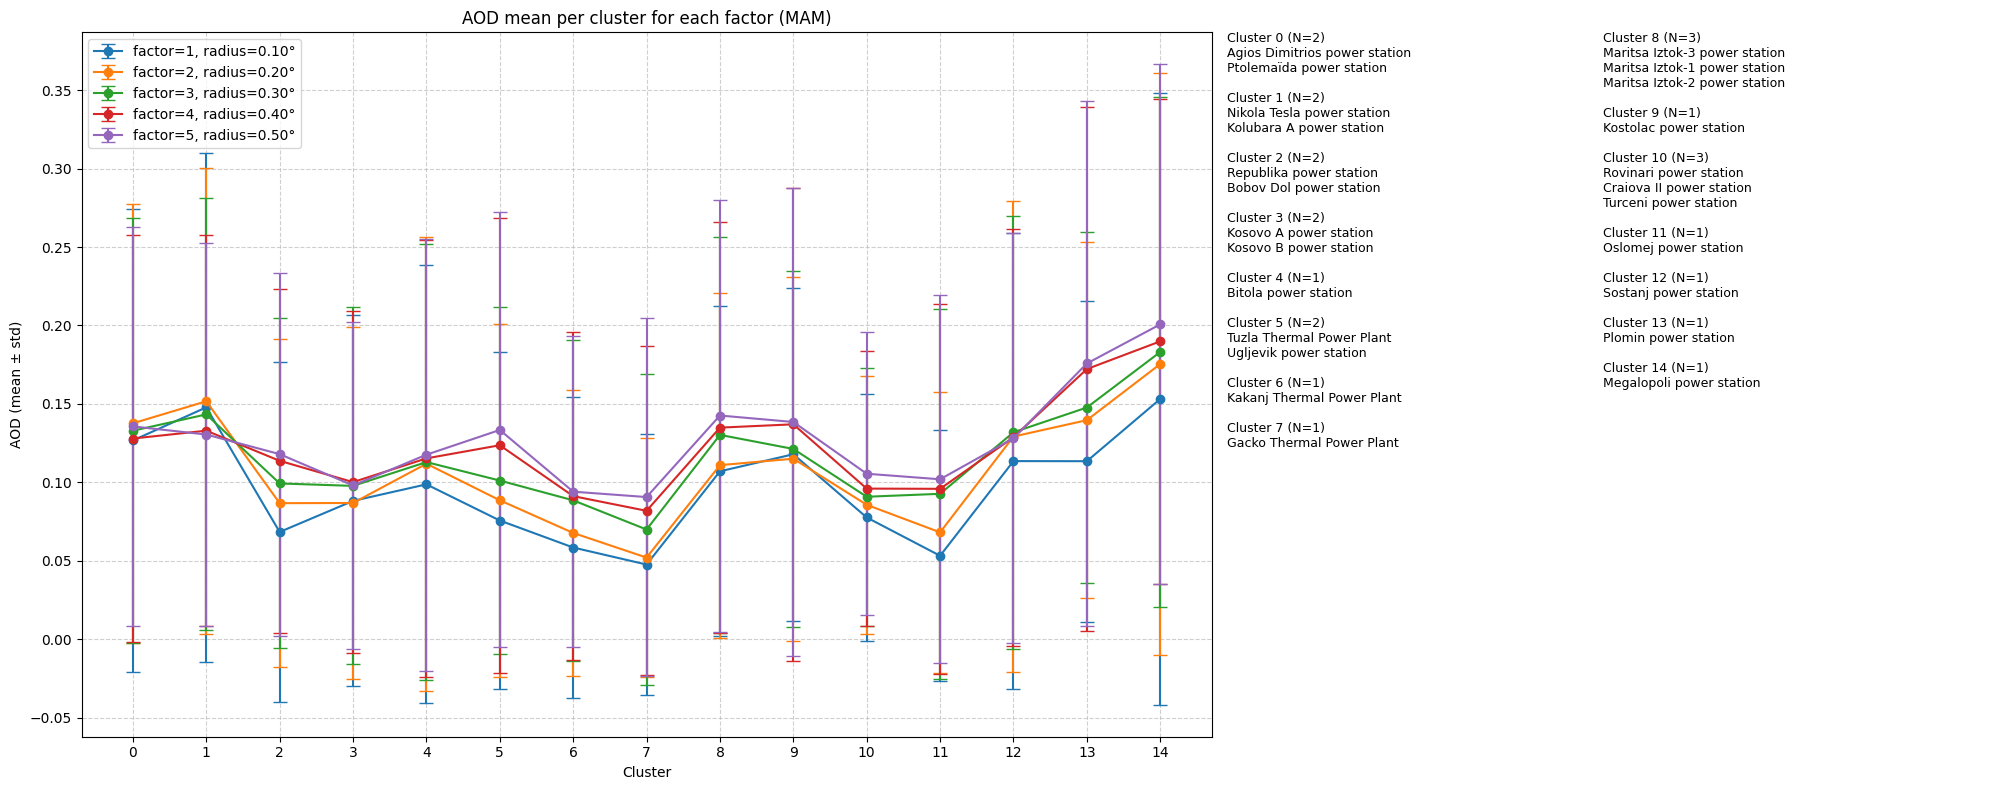

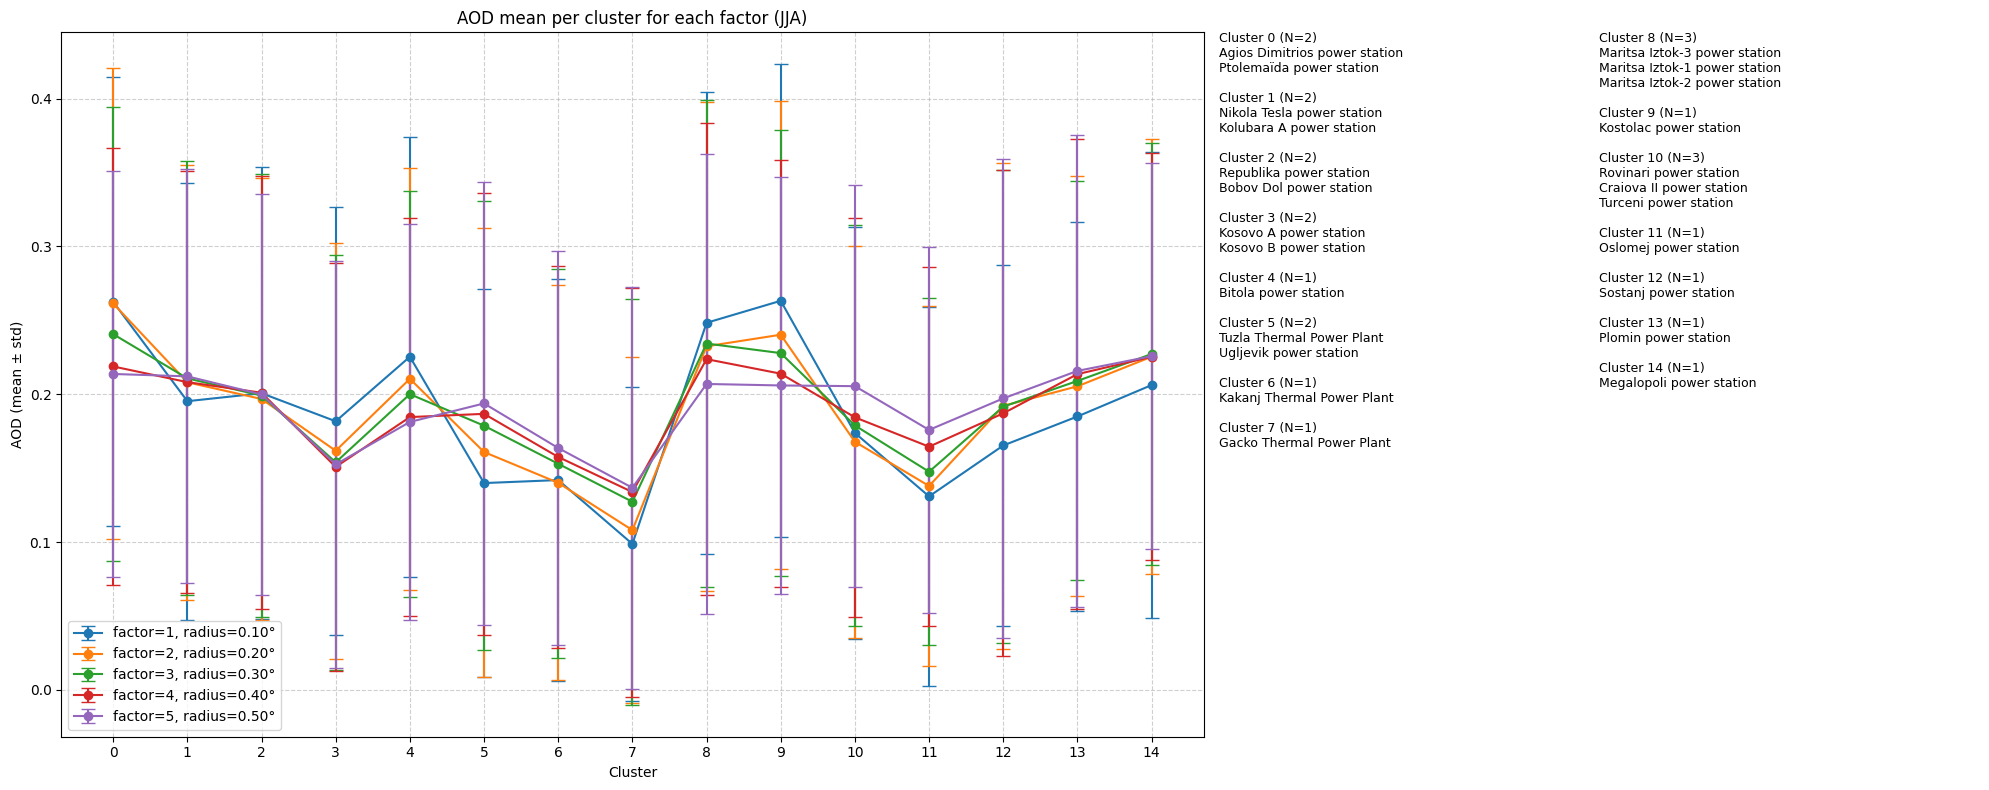

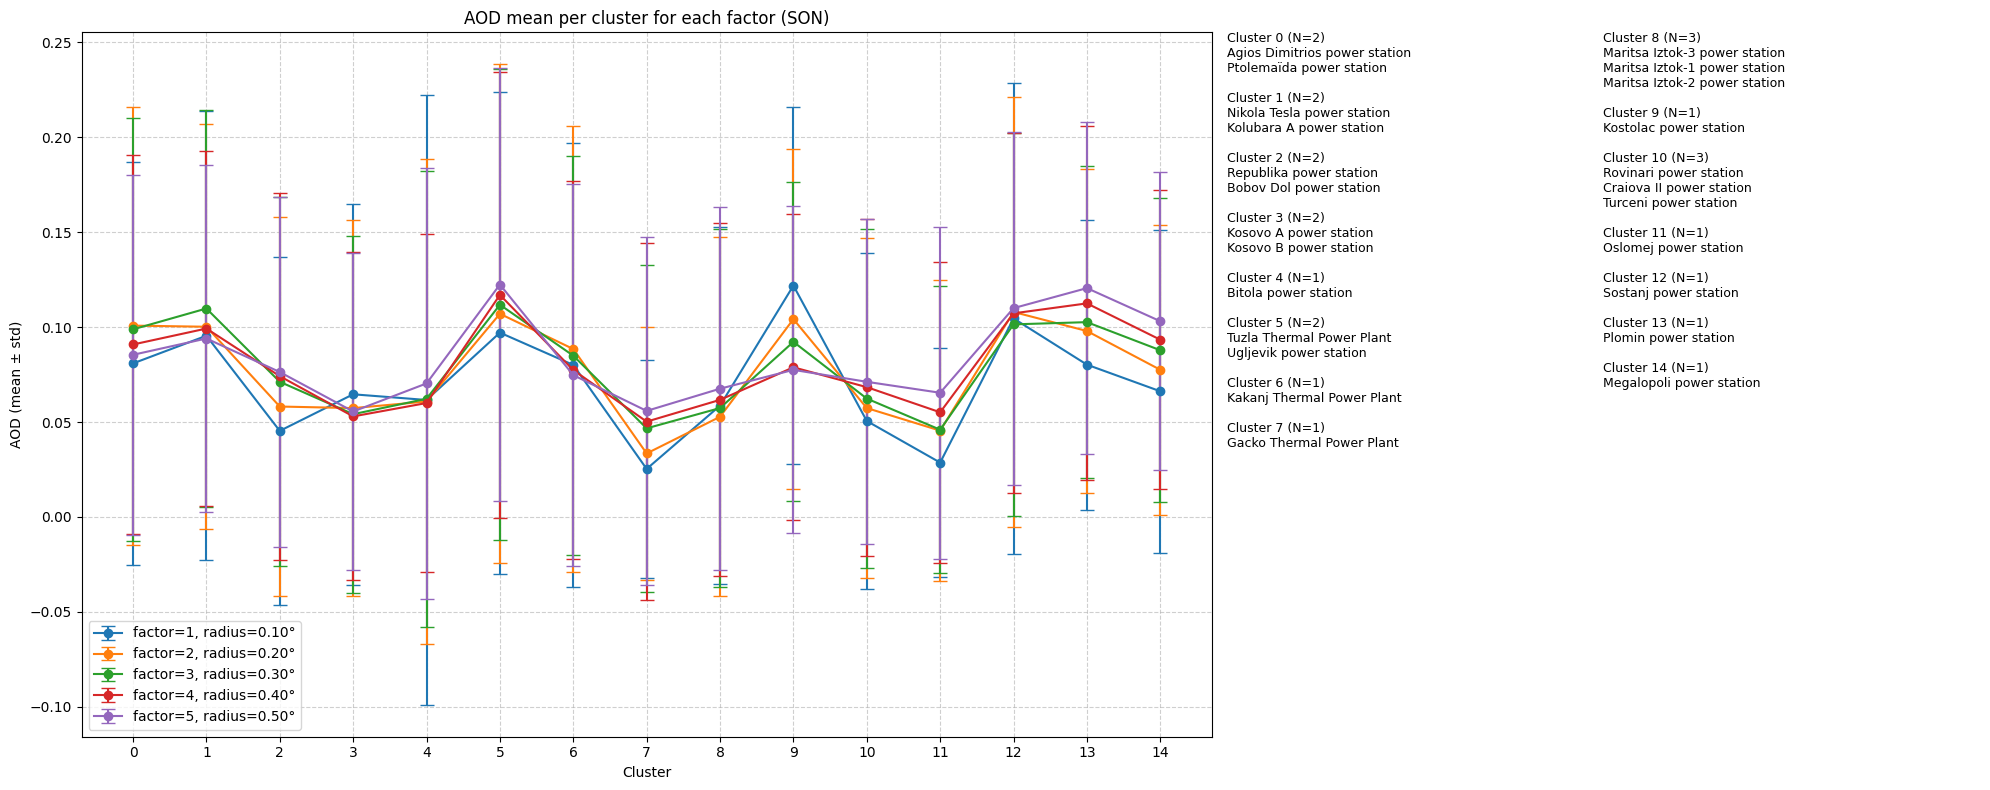

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

# Distinct seasons in your data
seasons = df_seasonal["Season"].unique()
seasons = ["DJF", "MAM", "JJA", "SON"]  # enforce order if desired

# Group plant names per cluster (ignore noise = -1)
cluster_groups = (
    df[df["Cluster"] != -1]
    .groupby("Cluster")["Name"]
    .apply(list)
    .sort_index()
)
clusters = cluster_groups.index

# ---- Loop over seasons ----
for season in seasons:
    df_s = df_seasonal[df_seasonal["Season"] == season]

    # ----- Create a 1x2 layout: left = plot, right = text -----
    fig = plt.figure(figsize=(20, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2])

    # ---- Left: Plot ----
    ax0 = plt.subplot(gs[0])

    for f in factors:
        sub = df_s[df_s["Factor"] == f]
        means = [
            sub[sub["Cluster"] == c]["AOD_Mean"].mean() for c in clusters
        ]
        stds = [
            sub[sub["Cluster"] == c]["AOD_STD"].mean() for c in clusters
        ]

        ax0.errorbar(
            clusters,
            means,
            yerr=stds,
            marker="o",
            capsize=5,
            label=f"factor={f}, radius={f * abs(lon_res):.2f}°"
        )

    ax0.set_xticks(clusters)
    ax0.set_xticklabels([str(c) for c in clusters])
    ax0.set_xlabel("Cluster")
    ax0.set_ylabel("AOD (mean ± std)")
    ax0.set_title(f"AOD mean per cluster for each factor ({season})")
    ax0.legend()
    ax0.grid(True, linestyle="--", alpha=0.6)

    # ---- Right: Text info ----
    ax1 = plt.subplot(gs[1])
    ax1.axis("off")

    # prepare cluster text blocks
    cluster_texts = []
    for c in clusters:
        names = "\n".join(cluster_groups[c])
        cluster_texts.append(f"Cluster {c} (N={len(cluster_groups[c])})\n{names}\n")

    # split into two columns
    mid = math.ceil(len(cluster_texts) / 2)
    col1 = "\n".join(cluster_texts[:mid])
    col2 = "\n".join(cluster_texts[mid:])

    ax1.text(0.0, 1, col1, va="top", ha="left", fontsize=9)
    ax1.text(0.5, 1, col2, va="top", ha="left", fontsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

clusters = range(len(aod_mean))

# AOD
plt.figure(figsize=(10,6))
for f_idx, f in enumerate(factors):
    means = [aod_mean[c][f_idx] for c in clusters]
    stds  = [aod_std[c][f_idx] for c in clusters]
    
    plt.errorbar(
        clusters,
        means,
        yerr=stds,
        marker="o",
        capsize=5,
        label=f"factor={f}"
    )

plt.xticks(clusters, [f"{c}" for c in clusters])
plt.xlabel("Cluster")
plt.ylabel("AOD (mean ± std)")
plt.title("AOD mean per cluster for each factor")
plt.legend()
plt.grid()
plt.show()
